# Business Understanding

Imports for this notebook

In [7]:
# Package Imports

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score, f1_score, classification_report
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Pipeline Imports
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import warnings
from pprint import pprint


# Data Understanding

In [9]:
df = pd.read_csv('./data/original_data.csv')

In [ ]:
df.info()

### EDA Summary
State, phone number, intl plan, voice mail plan are objects -- need to encode

Account Length - maybe days, how long customer has been with company

6 - 18 Usage Stats = number of calls number of minutes and charge for different time categories.

19 - # of customer service calls

Possible Churn Indicators:

- By State?
- High Customer Service Contact = high churn?
- Low Calls/Low minutes = higher churn?
- Can we identify a customer profile that is likely to churn for targeted marketing/incentives?
- Drop Phone number -- basically a unique identifer for every customer, not likely to help in predictions

- Location
    - State/Area Code
    
- Duration
    - Account Length
    
- Plan Types
    - Intl / Voicemail
    
- Usage Stats
    - minutes
    - num calls
    - charges
    - customer service calls

Drop Phone number

Encoding Process:
    - voicemail plan = labelencoder 1/0
    - international plan = 1/0
    - state - onehot encoding

Scale Numerical Features





In [10]:
# Drop phone number from the data set--in this context, it acts as a unique identifier with little meaningful context.
df.drop('phone number', axis=1, inplace=True)

### Churn Rate by State

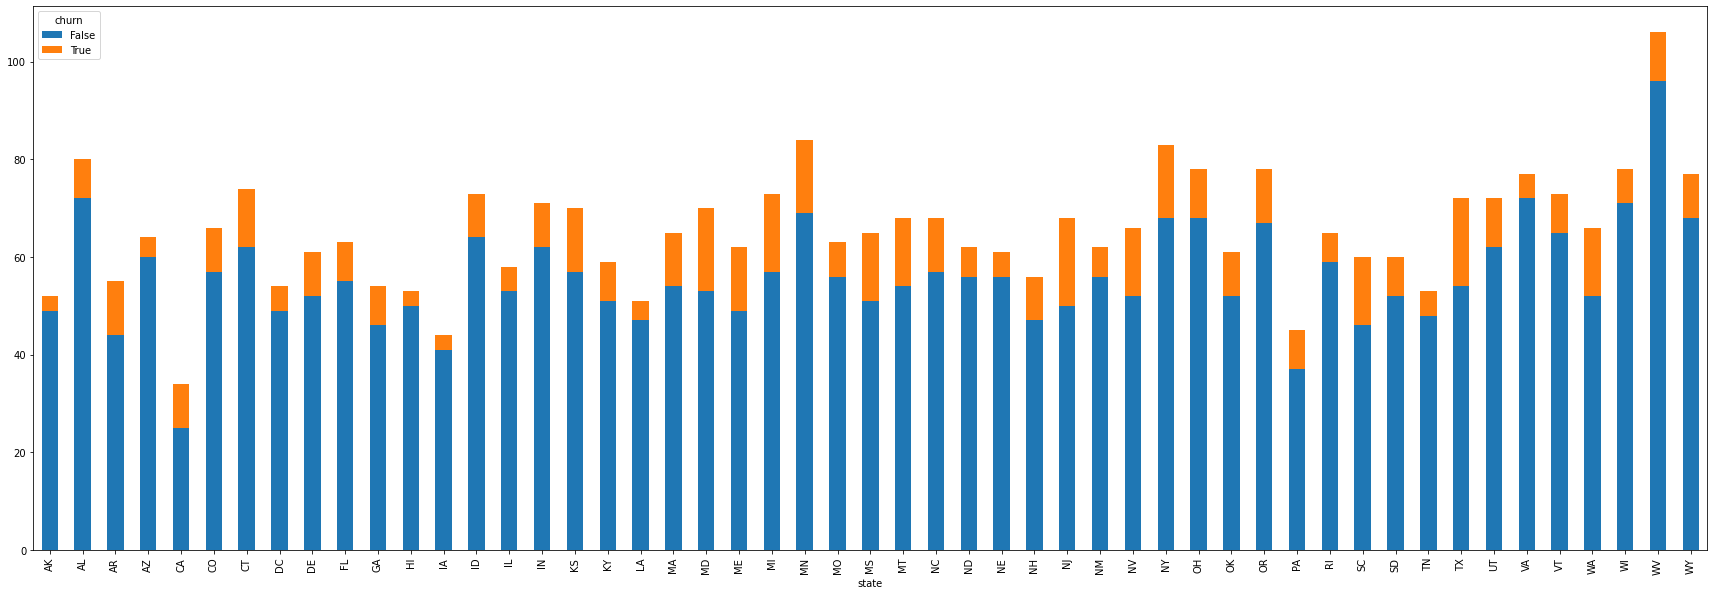

In [11]:
df.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10)); 

In [12]:
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

### Churn Rate by Area Code

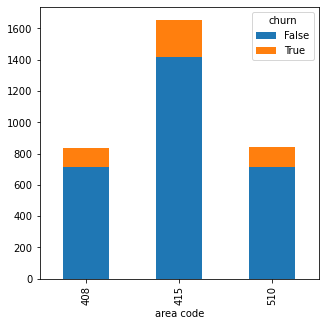

In [13]:
df.groupby(["area code", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

### Churn Rate by Voicemail Plan

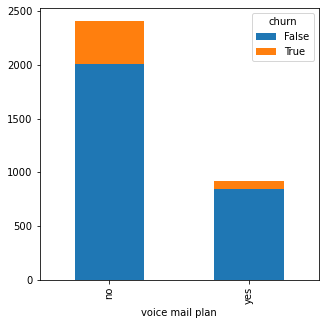

In [14]:
df.groupby(["voice mail plan", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(5,5));

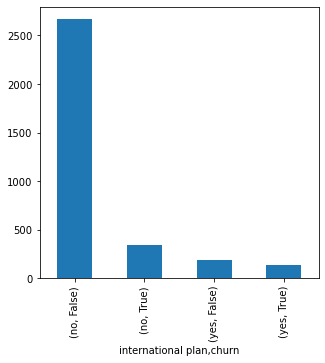

In [82]:
df.groupby(["international plan", "churn"]).size().plot(kind='bar', stacked=True, figsize=(5,5));

# Train Test Split

In [15]:
X = df.drop('churn', axis=1)
y = df['churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.33)

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2233 entries, 2360 to 3174
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   2233 non-null   object 
 1   account length          2233 non-null   int64  
 2   area code               2233 non-null   int64  
 3   international plan      2233 non-null   object 
 4   voice mail plan         2233 non-null   object 
 5   number vmail messages   2233 non-null   int64  
 6   total day minutes       2233 non-null   float64
 7   total day calls         2233 non-null   int64  
 8   total day charge        2233 non-null   float64
 9   total eve minutes       2233 non-null   float64
 10  total eve calls         2233 non-null   int64  
 11  total eve charge        2233 non-null   float64
 12  total night minutes     2233 non-null   float64
 13  total night calls       2233 non-null   int64  
 14  total night charge      2233 non-null

In [17]:
X_train['voice mail plan'].value_counts()

no     1621
yes     612
Name: voice mail plan, dtype: int64

In [18]:
# Define datatype of columns
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
cat_cols = [0, 3, 4]

## Pipeline Construction

- Smote Strategy
- Encoding based on datatype (subpipes & CT)
- 

In [19]:
# Google says avg churn rate is 22% for all providers, much lower for the major ones

sm = SMOTE(sampling_strategy=0.75, random_state=42)

In [20]:
# Define functions to identify and select columns based on the datatype stored in that column.

def get_numeric(df):
    return df.select_dtypes(include=['float64', 'int64'])

def get_categorical(df):
    return df.select_dtypes(include=['bool', 'object'])


# Create transformer objects using our get functions
GetNumeric = FunctionTransformer(get_numeric)
GetCategories = FunctionTransformer(get_categorical)

In [21]:
# Subpipelines to select and scale our numeric data / select and one-hot encode our categorical data.
subpipe_num = Pipeline(steps=[('num', GetNumeric),
                                ('ss', StandardScaler())])
 
subpipe_ohe = Pipeline(steps=[('cat', GetCategories), 
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

subpipe_ord = Pipeline(steps=[('ord', OrdinalEncoder())])

In [22]:
# Create lists of numeric and categorical columns.
num_cols = [1, 2, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
num_cols = list(df.columns[num_cols])
cat_cols = ['state']
ord_cols = [3, 4]
ord_cols = list(df.columns[ord_cols])

# Create ColumnTransformer object that contains our subpipes for column transformation
CT = ColumnTransformer(transformers=[
                                    ('subpipe_num', subpipe_num, num_cols),
                                    ('subpipe_ohe', subpipe_ohe, cat_cols),
                                    ('subpipe_ord', subpipe_ord, ord_cols)]
                      )

## Functions

Summary of functions needed

In [23]:
# This function will allow us to extract the column names of the data that is transformed in our pipelines.

def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_:#the last transformer is ColumnTransformer's 'remainder'
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: # if no 'get_feature_names' function, use raw column name
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

# Credit to Joey Gao @ https://github.com/scikit-learn/scikit-learn/issues/12525 for the shell of this function.

In [30]:
# This function will allow for quick cross-validation of the f1 score for each of our models.
def cross_val(model, X, y, kfolds=10):
    """ Perform cross-validated scoring and store/print results """
    f1_results = cross_val_score(model, X, y, cv=kfolds, scoring='f1')
    f1_mean = np.mean(f1_results)
    f1_median = np.median(f1_results)
    f1_std = np.std(f1_results)
    print(f"Mean f1 score: ", {f1_mean}, ".")
    print(f"Median f1 score: ", {f1_median}, ".")
    print(f"Standard Deviation in f1 score: ", {f1_std}, ".")

In [117]:
def get_feature_importance(model, mod_type, X, y):
    """ 
    Get feature importances, use get_column_names_from_ColumnTransformer grab column names and plot a horizontal bar
    graph of the 10 most important features when run on a pipeline that contains a model.
    """
    # Grab feature importances & column names
    feature_importance = model.named_steps[mod_type].feature_importances_
    feature_names = get_column_names_from_ColumnTransformer(CT)
    feature_names = [name.title() for name in feature_names]
    
    # Plot basic horizontal bar graph of 10 most important features.
    feat_importances = pd.DataFrame(model.named_steps[mod_type].feature_importances_, index=feature_names)
    feat_importances = feat_importances[0].nlargest(10)
    
   # plot_feats = zip(feature_names, feat_importances)
    
   # fig, ax = plt.subplots()
   # ax = plt.bar(feature_names, height=feat_importances)
    
    
    #feat_importances.plot(kind='barh',
     #                    figsize=(10,10),
     #                    title='Most Important Features that Predict Churn',
                #        plt.xlabel('Feature Importance'),
                #        set_ylabel('Customer Attribute')                         
    fig, ax = plt.subplots()
    ax = feat_importances.plot(kind='barh' , figsize=(10,10))
    ax.set_xlabel('Attribute Importance')
    ax.set_ylabel('Customer Attributes')
    ax.set_title('Attributes Most Predictive of Churn')

# Modelling

Summary of modelling approach

## Dummy Classifier

In [26]:
# Definte a pipeline to transform and smote our data using the subpipes defined above, and apply a Dummy Classifier
dummy_model_pipe = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dc', DummyClassifier(strategy='most_frequent', random_state=42))
                                       ]
                                )

In [31]:
dummy_model_pipe.fit(X_train, y_train)
cross_val(dummy_model_pipe, X_train, y_train)

Mean f1 score:  {0.0} .
Median f1 score:  {0.0} .
Standard Deviation in f1 score:  {0.0} .


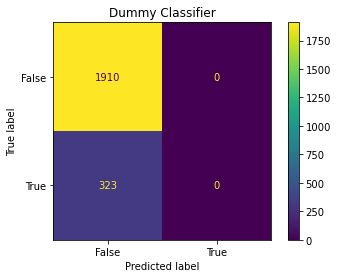

In [29]:
plot_confusion_matrix(dummy_model_pipe, X_train, y_train)
title = 'Dummy Classifier'
plt.title(title);

## Logistic Regression - First Simple Model

Summary of decision to use LR as simple model

In [32]:
# Define logistic regression pipeline using ColumnTransformer and Smote from above
lr_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('lr', LogisticRegression(random_state=42))
                                       ]
                                )



In [33]:
lr_pipeline.fit(X_train, y_train)

cross_val(lr_pipeline, X_train, y_train)

Mean f1 score:  {0.47585886006760036} .
Median f1 score:  {0.4835748792270531} .
Standard Deviation in f1 score:  {0.055112667756457956} .


In [34]:
lr_y_hat = lr_pipeline.predict(X_test)
print(classification_report(y_test, lr_y_hat))

              precision    recall  f1-score   support

       False       0.93      0.82      0.87       940
        True       0.38      0.65      0.48       160

    accuracy                           0.80      1100
   macro avg       0.66      0.74      0.68      1100
weighted avg       0.85      0.80      0.82      1100



In [ ]:
plot_confusion_matrix(lr_pipeline, X_test, y_test)
title = 'Logistic Regression'
plt.title(title);

## K-Nearest Neighbors

Summary of KNN / performance

In [38]:
knn_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('knn', KNeighborsClassifier())
                                       ]
                                )

In [39]:
knn_pipeline.fit(X_train, y_train)
cross_val(knn_pipeline, X_train, y_train)

Mean f1 score:  {0.44515018728655065} .
Median f1 score:  {0.4341013824884793} .
Standard Deviation in f1 score:  {0.03531257224889898} .


In [40]:
knn_y_hat = knn_pipeline.predict(X_train)
print(classification_report(y_train, knn_y_hat))

              precision    recall  f1-score   support

       False       1.00      0.86      0.92      1910
        True       0.54      0.98      0.70       323

    accuracy                           0.88      2233
   macro avg       0.77      0.92      0.81      2233
weighted avg       0.93      0.88      0.89      2233



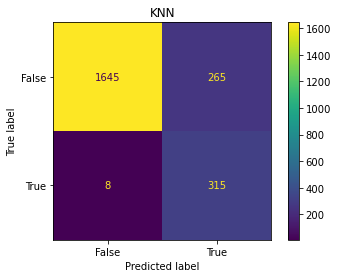

In [41]:
plot_confusion_matrix(knn_pipeline, X_train, y_train)
title = 'KNN'
plt.title(title);

# DecisionTree

Summary of DecisionTree performance

In [36]:
dt_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('dt', DecisionTreeClassifier(random_state=42))
                                       ]
                                )

In [37]:
dt_pipeline.fit(X_train, y_train)
cross_val(dt_pipeline, X_train, y_train)

Mean f1 score:  {0.6813362815421017} .
Median f1 score:  {0.6824175824175824} .
Standard Deviation in f1 score:  {0.07924240983682433} .


In [28]:
dt_y_hat = dt_pipeline.predict(X_train)
print(classification_report(y_train, dt_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



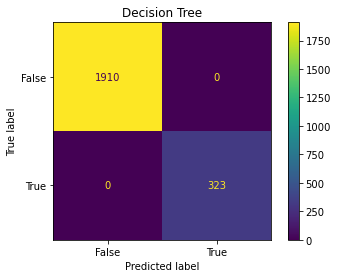

In [29]:
plot_confusion_matrix(dt_pipeline, X_train, y_train)
title = 'Decision Tree'
plt.title(title);

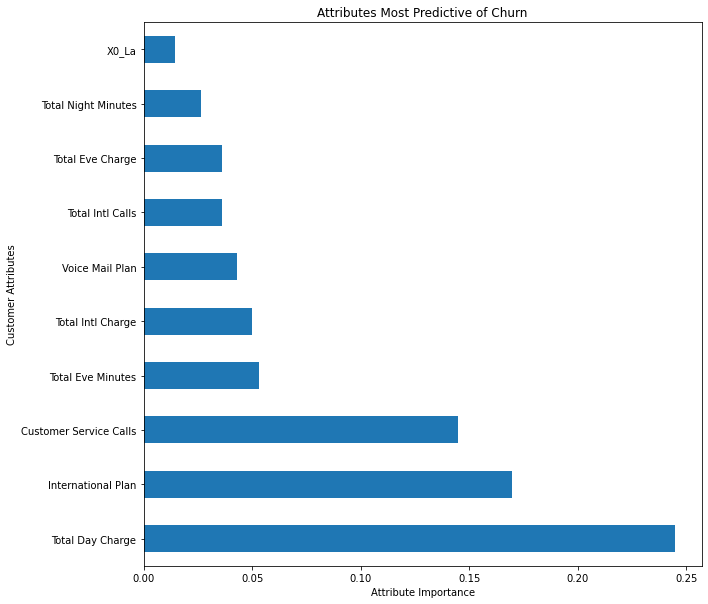

In [118]:
get_feature_importance(dt_pipeline, 'dt', X_train, y_train)

# Random Forest

In [45]:
rf_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rf', RandomForestClassifier(random_state=42))
                                       ]
                                )

In [46]:
rf_pipeline.fit(X_train, y_train)
cross_val(rf_pipeline, X_train, y_train)

Mean f1 score:  {0.7554505669905633} .
Median f1 score:  {0.7627118644067796} .
Standard Deviation in f1 score:  {0.057480336321058756} .


In [67]:
rf_y_hat = rf_pipeline.predict(X_train)
print(classification_report(y_train, rf_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



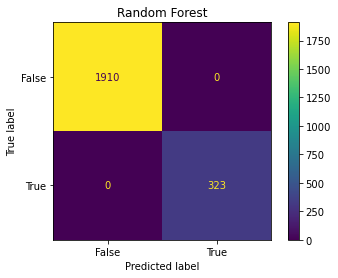

In [47]:
plot_confusion_matrix(rf_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

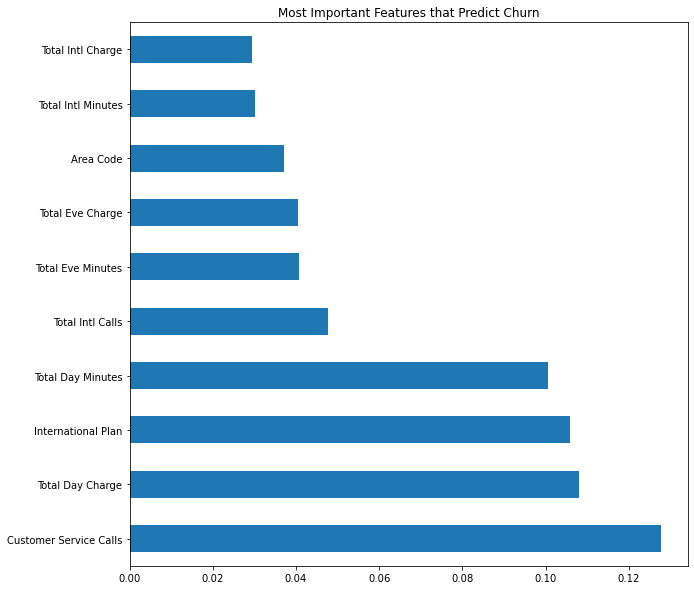

In [58]:
get_feature_importance(rf_pipeline, 'rf', X_train, y_train)

### Tuning Random Forest Classifier with Grid Search

summary of approach to tuning

In [66]:
# Print out original parameters of rf classifier in rf_pipeline
print('Current Parameters:\n')
pprint(rf_pipeline.named_steps['rf'].get_params())

Current Parameters:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [91]:
# Define new set of parameters to grid-search over
rf_params = {
            'rf__n_estimators': [10, 20, 30],
            'rf__min_samples_leaf': [1, 2, 4, 6],
            'rf__min_samples_split': [2, 5, 10],
            'rf__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'rf__bootstrap': [True, False]
             }

# Instantiate a grid search object using the parameters defined above.
rf_gs = GridSearchCV(rf_pipeline, param_grid=rf_params, n_jobs=-4, verbose=3, cv=10)

In [93]:
# Fit the grid search object on training data.
rf_gs.fit(X_train, y_train)

Fitting 10 folds for each of 720 candidates, totalling 7200 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-4)]: Done 281 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-4)]: Done 921 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-4)]: Done 1817 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-4)]: Done 2969 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-4)]: Done 4377 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-4)]: Done 6041 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-4)]: Done 7200 out of 7200 | elapsed:  1.9min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num',
                                                                                          FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['account '
                                                                          'length',
                                                                          'area '
                                                                          'code',
                                                  

In [95]:
# Find best parameters for initial grid search
rf_gs.best_params_

{'rf__bootstrap': False,
 'rf__max_depth': 30,
 'rf__min_samples_leaf': 4,
 'rf__min_samples_split': 10,
 'rf__n_estimators': 20}

#### 2nd Random Forest Grid Search

In [81]:
rf2_params = {
            'rf__criterion': ['gini', 'entropy'],
            'rf__n_estimators': [10, 15, 20, 25, 30],
            'rf__min_samples_leaf': [2, 3, 4, 5],
            'rf__min_samples_split': [2, 5, 10],
            'rf__max_depth': [10, 15, 20, 25, 30, 35, 40],
            'rf__bootstrap': [True, False]
             }

In [82]:
rf2_gs = GridSearchCV(rf_pipeline, param_grid=rf2_params, n_jobs=-4, verbose=3, cv=10)

In [83]:
rf2_gs.fit(X_train, y_train)

Fitting 10 folds for each of 1680 candidates, totalling 16800 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  18 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-4)]: Done 186 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-4)]: Done 506 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-4)]: Done 954 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-4)]: Done 1530 tasks      | elapsed:   21.0s
[Parallel(n_jobs=-4)]: Done 2234 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-4)]: Done 3066 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-4)]: Done 4026 tasks      | elapsed:   55.5s
[Parallel(n_jobs=-4)]: Done 5114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-4)]: Done 6330 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-4)]: Done 7674 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-4)]: Done 9146 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-4)]: Done 10746 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-4)]: Done 12474 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-4)]: Done 14330 tasks     

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num',
                                                                                          FunctionTransformer(func=<function get_numeric at 0x7fead03b5280>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['account '
                                                                          'length',
                                                                          'area '
                                                                          'code',
                                                  

In [84]:
rf2_gs.best_params_

{'rf__bootstrap': False,
 'rf__criterion': 'entropy',
 'rf__max_depth': 20,
 'rf__min_samples_leaf': 2,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 25}

## RF Tuned

In [60]:
rft_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('rft', RandomForestClassifier(bootstrap= False,
                                                                    max_depth=30,
                                                                    min_samples_leaf=4,
                                                                    min_samples_split=10,
                                                                    n_estimators=20,
                                                                    random_state=42))
                                       ]
                                )

In [61]:
rft_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fedd81b9310>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [62]:
rf_y_hat = rf_pipeline.predict(X_train)
print(classification_report(y_train, rf_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



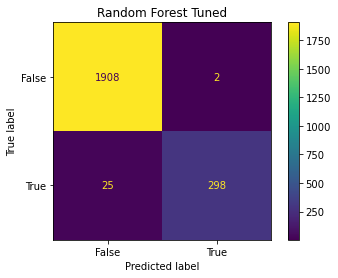

In [63]:
plot_confusion_matrix(rft_pipeline, X_train, y_train)
title = 'Random Forest Tuned'
plt.title(title);

In [64]:
cross_val(rft_pipeline, X_train, y_train)

Mean f1 score:  {0.7705981178380934} .
Median f1 score:  {0.783273131425396} .
Standard Deviation in f1 score:  {0.067167064987285} .


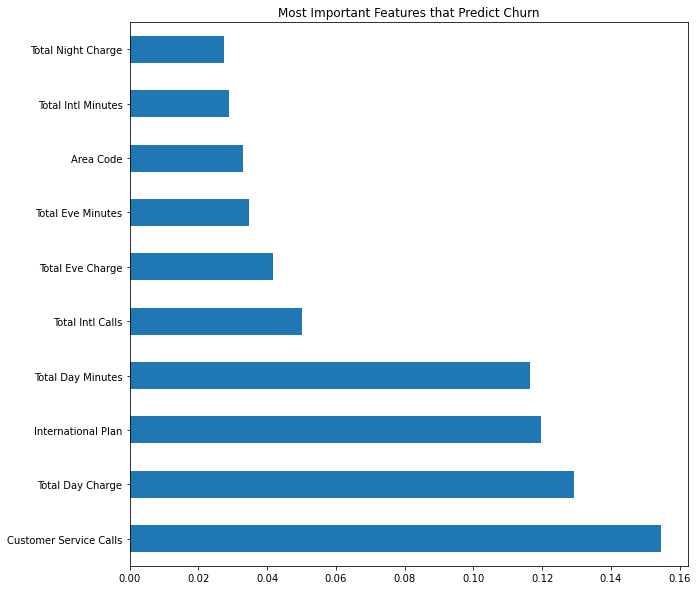

In [65]:
rft_importances = get_feature_importance(rft_pipeline, 'rft', X_train, y_train)

# Naive Bayes

short summary of performance, use-case

In [51]:
nb_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('nb', GaussianNB())
                                       ]
                                )

In [52]:
nb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num',
                                                                   FunctionTransformer(func=<function get_numeric at 0x7fead03b5280>)),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['account length',
                                                   'area code',
                                                   'number vmail messages',
                                                   'total day minutes',
                                                   'total day calls',
                                                   'total day charge',
                                                   'total eve minutes',
                                               

In [53]:
nb_y_hat = nb_pipeline.predict(X_train)
print(classification_report(y_train, nb_y_hat))

              precision    recall  f1-score   support

       False       0.91      0.56      0.70      1910
        True       0.21      0.69      0.32       323

    accuracy                           0.58      2233
   macro avg       0.56      0.63      0.51      2233
weighted avg       0.81      0.58      0.64      2233



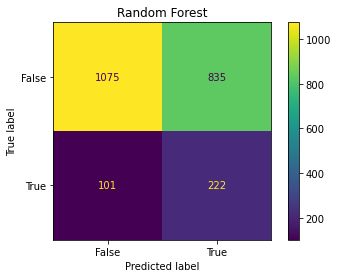

In [54]:
plot_confusion_matrix(nb_pipeline, X_train, y_train)
title = 'Random Forest'
plt.title(title);

In [55]:
cross_val(nb_pipeline, X_train, y_train)

Mean f1 score:  {0.2815993245174138} .
Median f1 score:  {0.28008130081300814} .


## Gradiant Boosted Classifier

summary of rationale for use & performance

In [50]:
gbc_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbc', GradientBoostingClassifier())
                                       ]
                                )

In [51]:
gbc_pipeline.fit(X_train, y_train)
cross_val(gbc_pipeline, X_train, y_train)

Mean f1 score:  {0.7859687234765189} .
Median f1 score:  {0.7732497387669801} .
Standard Deviation in f1 score:  {0.054666165301894755} .


In [56]:
gbc_y_hat = gbc_pipeline.predict(X_train)
print(classification_report(y_train, gbc_y_hat))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98      1910
        True       0.92      0.80      0.86       323

    accuracy                           0.96      2233
   macro avg       0.94      0.90      0.92      2233
weighted avg       0.96      0.96      0.96      2233



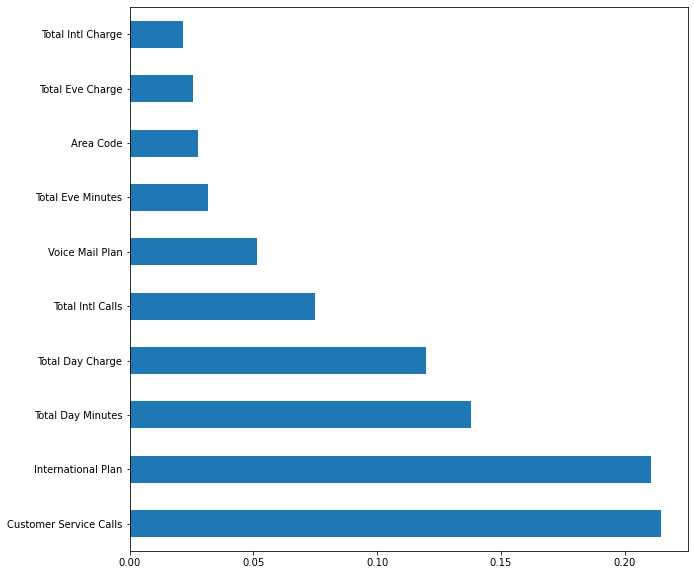

In [58]:
gbc_importances = get_feature_importance(gbc_pipeline, 'gbc', X_train, y_train)

### GridSearch--Gradiant Boosted Classifier

In [85]:
# Print out original parameters of rf classifier in gbc_pipeline
print('Current Parameters:\n')
pprint(gbc_pipeline.named_steps['gbc'].get_params())

Current Parameters:

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}


In [101]:
# Define parameter grid to search over
gbc_params = {
            'gbc__n_estimators': [10, 20, 30],
            'gbc__min_samples_leaf': [1, 2, 4, 6],
            'gbc__min_samples_split': [2, 3, 4, 5, 10],
            'gbc__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            'gbc__learning_rate': [0.05, 0.1, 0.2, 0.3]
             }

# Instantiate grid search object using parameters defined above.
gbc_gs = GridSearchCV(gbc_pipeline, param_grid=gbc_params, n_jobs=-4, verbose=3, cv=10)

In [103]:
# Fit the grid search object on training data
# gbc_gs.fit(X_train, y_train)

Fitting 10 folds for each of 2400 candidates, totalling 24000 fits


[Parallel(n_jobs=-4)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-4)]: Done  18 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-4)]: Done 114 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-4)]: Done 274 tasks      | elapsed:   23.0s
[Parallel(n_jobs=-4)]: Done 498 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-4)]: Done 786 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-4)]: Done 1138 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-4)]: Done 1554 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-4)]: Done 2034 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-4)]: Done 2578 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-4)]: Done 3186 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-4)]: Done 3858 tasks      | elapsed:  8.8min
[Parallel(n_jobs=-4)]: Done 4594 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-4)]: Done 5394 tasks      | elapsed: 12.8min
[Parallel(n_jobs=-4)]: Done 6258 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-4)]: Done 7186 tasks      | e

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num',
                                                                                          FunctionTransformer(func=<function get_numeric at 0x7fb1cbebcb80>)),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['account '
                                                                          'length',
                                                                          'area '
                                                                          'code',
                                                  

In [104]:
# Get best parameters from first grid search
gbc_gs.best_params_

{'gbc__learning_rate': 0.3,
 'gbc__max_depth': 10,
 'gbc__min_samples_leaf': 4,
 'gbc__min_samples_split': 4,
 'gbc__n_estimators': 30}

In [ ]:
# Trial Run 1:
# {'gbc__learning_rate': 0.3,
#  'gbc__max_depth': 10,
#  'gbc__min_samples_leaf': 4,
#  'gbc__min_samples_split': 4,
#  'gbc__n_estimators': 30}

## GBC Tuned

Using the best parameters identified by our grid search, we re-ran the gradient boosted classifer on the training data. Results were...

In [53]:
gbc_tuned_pipeline = ImPipeline(steps=[
                                        ('ct', CT),
                                        ('sm', sm),
                                        ('gbct', GradientBoostingClassifier(learning_rate=0.3, 
                                                                           max_depth=10,
                                                                           min_samples_leaf=4,
                                                                           min_samples_split=4,
                                                                           n_estimators=30))]
                                )

In [54]:
gbc_tuned_pipeline.fit(X_train, y_train)
cross_val(gbc_tuned_pipeline, X_train, y_train)

Mean f1 score:  {0.8155313677542264} .
Median f1 score:  {0.8125} .
Standard Deviation in f1 score:  {0.04057834210417415} .


In [61]:
gbc_tuned_y_hat = gbc_tuned_pipeline.predict(X_train)
print(classification_report(y_train, gbc_tuned_y_hat))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1910
        True       1.00      1.00      1.00       323

    accuracy                           1.00      2233
   macro avg       1.00      1.00      1.00      2233
weighted avg       1.00      1.00      1.00      2233



AttributeError: 'Rectangle' object has no property 'set_xlabel'

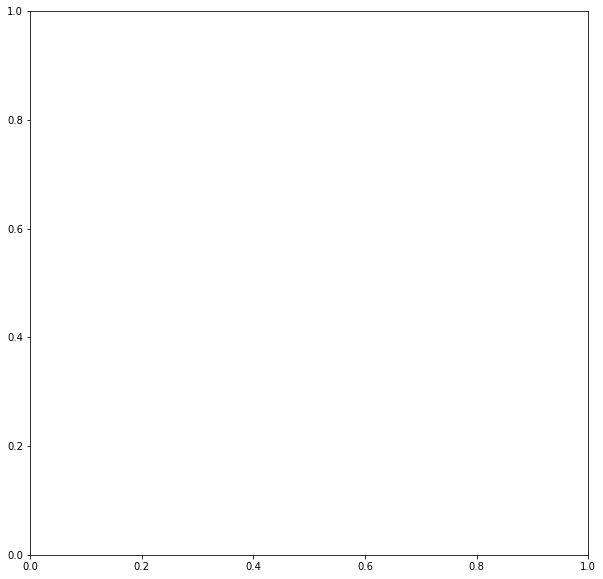

In [80]:
# Plot the 10 most important features
get_feature_importance(gbc_tuned_pipeline, 'gbct', X_train, y_train)

## Final Model & Evaluation

In [ ]:
# Final_model = grid_searched_pipeline.best_estimator_